In [1]:
from gensim.models import Word2Vec
from scoring import Scoring
import pandas as pd
import numpy as np

# Iterative approach using vector representation of messages

In [12]:
# ---- Leemos el primer diccionario de palabras prototípicas ----
# lista_asela_df = pd.read_csv('data/palabras_asela.csv')
# lista_asela_df.drop(columns=['Positiva o Negativa'],inplace=True)
# lista_asela_df.rename(columns={'Unnamed: 0':'word' , 'pos-neg':'prescore'},inplace=True)
# W0_dict = dict(zip(lista_asela_df['word'].values,lista_asela_df['prescore'].values))


# ---- Leemos el diccionario de palabras prototípicas de Alba ----
# lista_alba_df = pd.read_csv('data/clinical-prescores.csv',index_col=0)
# lista_alba_df['c-prescore'] = 0.2*lista_alba_df['c-prescore']
# lista_alba_df.rename(columns={'c-prescore':'prescore'},inplace=True)
# W0_dict = dict(zip(lista_alba_df['word'].values,lista_alba_df['prescore'].values))

# ---- Leemos el diccionario de palabras prototípicas automáticas ----
W0_dict = pd.read_pickle("data/palabras_auto.pickle")

w2v_model = Word2Vec.load("data/word2vec.model")

# ---- Leemos los mensajes ----
msjs_df = pd.read_csv("data/sms_full_dataframe.csv",index_col=0)
msjs_df['Normalized Label'] = (2/5)*msjs_df['ds'].values-1
y = msjs_df['ds'].values

In [13]:
import xgboost as xgb
from sklearn.svm import SVC

def clasificador(x_train,y_train,x_test,y_test,method='svc'):
    if method=='svc':
        clf = SVC(kernel='rbf')
        clf.fit(X=x_train,y=y_train)
        y_pred = clf.predict(x_test)
    elif method=='xgb':
        num_round = 10
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dtest = xgb.DMatrix(x_test, label=y_test)
        # DEFINIR LOS PARÁMETROS
        param = {'max_depth': 2, 'eta': 1, 'objective': 'multi:softmax',
                'nthread': 4, 'num_class': 6}
        evallist = [(dtest, 'eval'), (dtrain, 'train')]
        # HACER EL ENTRENAMIENTO USANDO XGBOOST
        bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=True)  
        y_pred = bst.predict(dtest)
        y_pred = [round(value) for value in y_pred]
    return y_pred

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score


n_iterations = 5

accs = []
precs = []
recs = []

for k in range(n_iterations):
    puntaje = Scoring(w2vmodel=w2v_model,W0=W0_dict)
    puntaje.build_neighbors(alpha=0.95)
    scores_df = puntaje.transform(df=msjs_df,text_col="Texto",label_col="Normalized Label",beta1=0.5,beta2=5.5)
    W0_dict = dict(zip(scores_df['word'].values,scores_df['score'].values))
    _ = puntaje.get_words_representations(mode='mean')
    # X_msjs_rep = puntaje.get_texts_representations_Nmean(n=4)
    # X_msjs_rep = puntaje.get_texts_representations_mean()
    X_msjs_rep = puntaje.get_texts_representations_PCA()
    X_train, X_test, y_train, y_test = train_test_split(X_msjs_rep, y, random_state=331,train_size=0.75) 
    y_pred = clasificador(X_train,y_train,X_test,y_test,method='xgb')
    print(np.unique(y_pred))
    accs.append(accuracy_score(y_test,y_pred))
    recs.append(recall_score(y_test,y_pred,average='macro'))
    precs.append(precision_score(y_test,y_pred,average='macro'))
    print(f"{k+1}/{n_iterations} done...")

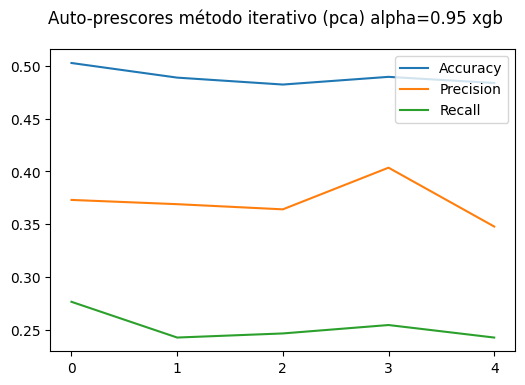

In [15]:
import matplotlib.pyplot as plt

title = "Auto-prescores método iterativo (pca) alpha=0.95 xgb"

plt.figure(dpi=100)
plt.suptitle(title)
plt.plot(range(n_iterations),accs,label='Accuracy')
plt.plot(range(n_iterations),precs,label='Precision')
plt.plot(range(n_iterations),recs,label='Recall')
plt.xticks([k for k in range(n_iterations)])
plt.legend(loc='best')
plt.savefig(title+".png")
plt.show()


In [18]:
print(accs)
print(precs)
print(recs)

[0.4741442097596504, 0.47560087399854334, 0.47560087399854334, 0.47560087399854334, 0.47560087399854334]
[0.5640907825118352, 0.6070353649360422, 0.6070353649360422, 0.6070353649360422, 0.6070353649360422]
[0.19016227365209104, 0.19192571671077022, 0.19192571671077022, 0.19192571671077022, 0.19192571671077022]


# Probar el API de Scoring

In [1]:
import pandas as pd
from gensim.models import Word2Vec

w2v_model = Word2Vec.load("data/word2vec.model")

# ---- Leemos los mensajes ----
msjs_df = pd.read_csv("data/sms_full_dataframe.csv",index_col=0)
# msjs_df['Normalized Label'] = (2/5)*msjs_df['ds'].values-1
# y = msjs_df['ds'].values

msjs_df.sample(3)

,Llave,Paciente,Sexo,cal_vida,Texto,ds03,ds45,dp0,dp1,ds0,ds1,ds2,ds3,ds4,ds5,ds,dp
3243,14740,6753,2,17.6,día reseñar,1,0,0,1.0,0,0,0,1,0,0,3,1.0
4422,17294,10148,2,0.0,ayer dando paseo diario pinares colindantes ca...,1,0,0,1.0,1,0,0,0,0,0,0,1.0
1510,9716,3205,2,68.0,cansancio derivado exceso ejercicio agujetas,0,1,1,0.0,0,0,0,0,0,1,5,0.0


In [2]:
from experiment_tools_SA import SentimentAnalysis


# betas1 = [0.5,1,2]#np.linspace(0.1,2,5)
# betas2 = [0.5,1,2]#np.linspace(0.5,5,5)
# nums_cols = [3,5,7]
# alphas = [0.5,0.75,0.9]#np.linspace(0.25,0.98,5)

# params_dict = {
#                 # 'beta1':betas1,
#                 # 'beta2':betas2,
#                 'n_cols':nums_cols
#                 # 'alpha':alphas
#                 }



hpd = {'emb_model': w2v_model}

sa = SentimentAnalysis(hyper_params_dict=hpd,
                        df=msjs_df,
                        text_col_name='Texto',
                        label_col_name='ds',
                        )

Dataframe contains entries with 6 labels:
[0 1 2 3 4 5]


In [3]:
comb_dict = {
            'beta1': 0.5,
            'beta2': 2,
            'n_cols': 7,
            'alpha': 0.9,
            'top_n': 50,
            'n_iter':3
            }

results = sa.run(combination_dict=comb_dict)

Calculando palabras prototípicas... 

/home/wini/Repositorios/SA-paper/SentimentKW.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_tr_df = labels_tr_df.append(temp_tr_df,ignore_index=True)
/home/wini/Repositorios/SA-paper/SentimentKW.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_tr_df = labels_tr_df.append(temp_tr_df,ignore_index=True)
/home/wini/Repositorios/SA-paper/SentimentKW.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_tr_df = labels_tr_df.append(temp_tr_df,ignore_index=True)
/home/wini/Repositorios/SA-paper/SentimentKW.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_tr_df = labels_tr_df.append(temp_tr_df,ignore_inde

done in 345.43282
Construyendo vecinos... done in 444.97962
Calculando puntajes... done in 6.94717
Calculando representaciones... done in 4.28128
43/43 [==============================] - 0s 4ms/step - loss: 1.3470 - accuracy: 0.5237
done in 11.47281
Construyendo vecinos... 

In [ ]:
print(results)